In [69]:
%pip install gseapy
%pip install pyvis


[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip



Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import io
import networkx as nx
import gseapy as gp
from networkx.algorithms import community 
from pyvis.network import Network

# Base GSE102741 (Cérebro)

In [12]:
df = pd.read_csv(r"../../data/raw/GSE102741 (dados brutos)/GSE102741_log2RPKMcounts.csv")
df

,Gene_ID,sample1,sample2,sample3,sample4,sample5,sample6,sample7,sample8,sample9,...,sample43,sample44,sample45,sample46,sample47,sample48,sample49,sample50,sample51,sample52
0,ENSG00000262352,0.021219,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.017205,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,ENSG00000263305,0.197745,0.262296,0.000000,0.161346,0.174307,0.085869,0.036811,0.158465,0.370495,...,0.445371,0.257549,0.163261,0.375589,0.258014,0.206019,0.146575,0.000000,0.186447,0.194884
2,ENSG00000173213,0.029607,0.005403,0.031364,0.023895,0.004747,0.012434,0.005253,0.007859,0.032747,...,0.011285,0.000000,0.005411,0.016057,0.012217,0.023253,0.010846,0.000000,0.004674,0.009033
3,ENSG00000262735,0.000000,0.015701,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.019191,...,0.000000,0.016485,0.015725,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,ENSG00000262081,0.045226,0.000000,0.000000,0.000000,0.000000,0.006379,0.000000,0.000000,0.000000,...,0.008674,0.000000,0.016558,0.000000,0.000000,0.000000,0.008337,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43866,ENSG00000198695,6.056248,4.676502,5.392452,6.316724,5.096222,3.108422,4.209943,4.253688,6.474179,...,5.554522,6.205202,6.043328,5.957290,5.394434,5.794652,5.449433,5.255066,6.130244,4.951935
43867,ENSG00000210194,1.846970,0.956130,1.908170,3.144990,1.754405,0.707106,1.174153,0.424521,2.106854,...,2.886479,3.153607,2.968314,2.903938,2.534624,0.886078,2.576118,0.852453,1.447741,1.363844
43868,ENSG00000198727,6.924384,7.179162,8.687671,7.565837,7.790482,5.908187,6.373977,6.304338,7.386145,...,6.986980,7.423792,7.110690,6.920476,6.643292,6.413440,6.777001,6.767887,7.227845,6.583624
43869,ENSG00000210195,5.163860,4.744123,6.078200,6.069662,5.396130,5.342773,5.090934,4.442633,6.587456,...,5.654446,5.066741,6.177219,4.654553,3.899438,4.522941,5.434720,3.203405,4.828526,5.052452


In [13]:
gene_col = "Gene_ID"
expr_cols = [c for c in df.columns if c.startswith("sample")]

# Convert to float
df[expr_cols] = df[expr_cols].apply(pd.to_numeric, errors="coerce")

# Remove values without variance across samples
df = df[df[expr_cols].var(axis=1) > 0]

In [15]:
annot = pd.read_csv(r"../../data/raw/GSE102741 (dados brutos)/mart_export.csv")
expr = df.copy()

In [17]:
expr["Gene_ID"] = expr["Gene_ID"].str.split(".").str[0]
if "Gene stable ID" in annot.columns:
    annot["Gene stable ID"] = annot["Gene stable ID"].str.split(".").str[0]

merged = expr.merge(annot, left_on="Gene_ID", right_on="Gene stable ID", how="left")

merged["Gene name"] = merged["Gene name"].fillna(merged["Gene_ID"])  

merged = merged.drop_duplicates(subset=["Gene_ID"])
print(f"Dataset final: {merged.shape[0]} genes × {merged.shape[1]} colunas")

Dataset final: 43871 genes × 56 colunas


In [18]:
expr_matrix = merged.drop(columns=["Gene stable ID", "Gene description", "Gene_ID"]).set_index("Gene name")

variances = expr_matrix.var(axis=1)
top_genes = variances.sort_values(ascending=False).head(500).index  
expr_top = expr_matrix.loc[top_genes]
corr_matrix = expr_top.T.corr(method="pearson")

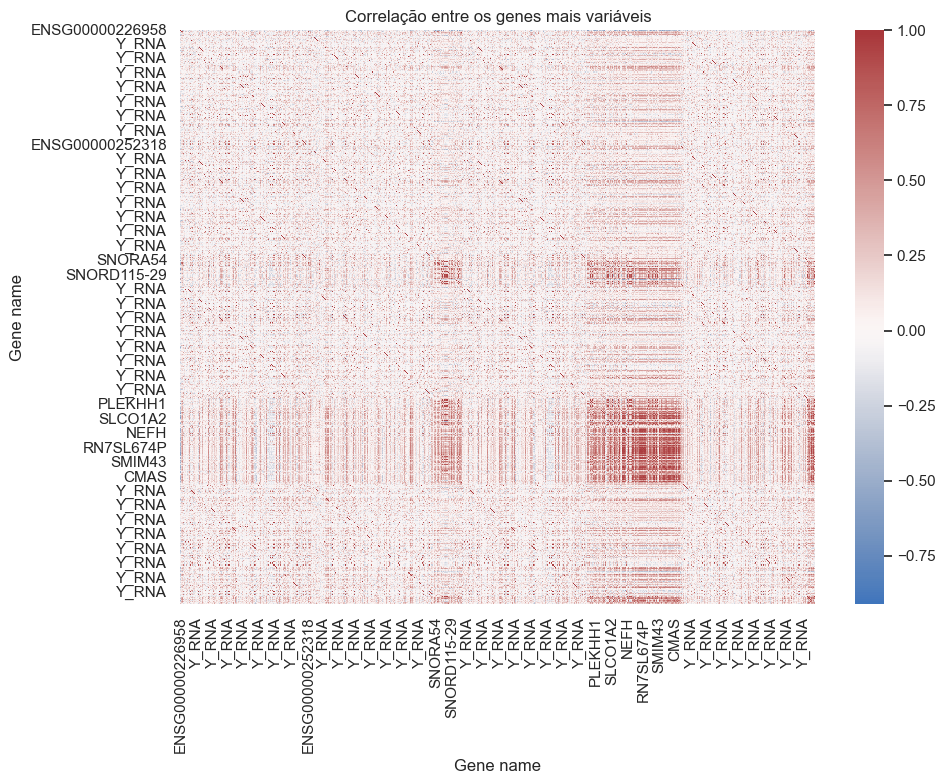

In [74]:
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, cmap="vlag", center=0)
plt.title("Correlação entre os genes mais variáveis")
plt.tight_layout()
plt.savefig("../../assets/images/correlação_entre_genes_mais_variaveis.png")
plt.show()

Grafo contém 394 genes e 8484 interações fortes.
Detectados 18 clusters de coexpressão.


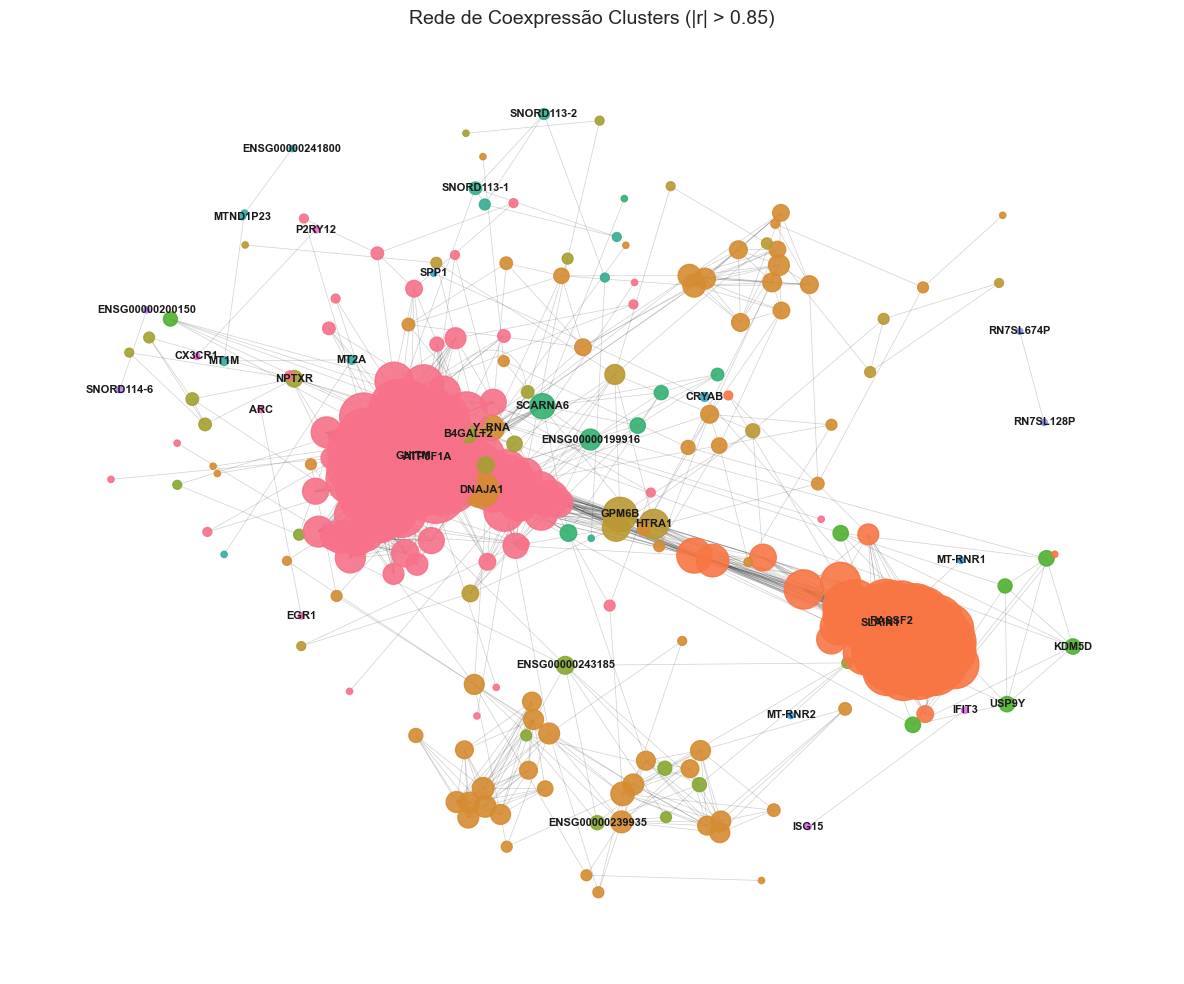

In [75]:
threshold = 0.85
edges = np.where(np.abs(corr_matrix) > threshold)
edges = [
    (corr_matrix.index[i], corr_matrix.columns[j], corr_matrix.values[i, j])
    for i, j in zip(*edges) if i < j
]

G = nx.Graph()
G.add_weighted_edges_from(edges)
print(f"Grafo contém {G.number_of_nodes()} genes e {G.number_of_edges()} interações fortes.")

centrality = nx.degree_centrality(G)
nx.set_node_attributes(G, centrality, "centrality")

communities = list(community.greedy_modularity_communities(G))
cluster_map = {}
for i, c in enumerate(communities):
    for node in c:
        cluster_map[node] = i
nx.set_node_attributes(G, cluster_map, "cluster")

print(f"Detectados {len(communities)} clusters de coexpressão.")


pos = nx.spring_layout(G, seed=42, k=0.25)


palette = sns.color_palette("husl", len(communities))
node_colors = [palette[cluster_map[g]] for g in G.nodes()]
node_sizes = [8000 * centrality[g] for g in G.nodes()]


labels = {}
for i, comm in enumerate(communities):
    sorted_nodes = sorted(comm, key=lambda g: centrality[g], reverse=True)
    for node in sorted_nodes[:2]:
        labels[node] = node


plt.figure(figsize=(12, 10))
nx.draw_networkx_edges(G, pos, alpha=0.2, width=0.5)
nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=node_colors, alpha=0.9)
nx.draw_networkx_labels(G, pos, labels=labels, font_size=8, font_weight='bold')

plt.title(f"Rede de Coexpressão Clusters (|r| > {threshold})", fontsize=14)
plt.axis("off")
plt.tight_layout()
plt.savefig("../../assets/images/rede_coexpressao_cerebro.png")
plt.show()

In [76]:
#Generate genes per clusters
cluster_genes = {i: list(comm) for i, comm in enumerate(communities)}

#Create a dataframe with genes and clusters
df_clusters = pd.DataFrame(
    [(gene, cluster_map[gene]) for gene in G.nodes()],
    columns=["Gene_ID", "Cluster"]
)

# Adiciona o Gene Name, se você tiver essa coluna no seu df principal
if "Gene name" in df.columns:
    df_clusters = df_clusters.merge(
        df[["Gene_ID", "Gene name"]], on="Gene_ID", how="left"
    )

# Salva pra referência
df_clusters.to_csv("../../data/interim/gene_clusters.csv", index=False)
print("Clusters salvos em 'data/interim/gene_clusters.csv'")


Clusters salvos em 'data/interim/gene_clusters.csv'


In [78]:
df_genes_asd_controle = pd.read_csv(r"../../data/processed/cérebro/ASD_and_Control_log2RPKMmean_expressos significativamente em amostras TEA e controle.csv")
df_genes_asd = pd.read_csv(r"../../data/processed/cérebro/ASD_log2RPKMmean_expressos significativamente somente em amostras TEA.csv")
df_diff_exp_tea = pd.read_csv(r"../../data/processed/cérebro/Expressão diferencial - somente em amostras TEA.csv", sep=";")
df_merged = merged.copy()

In [79]:
def convert_to_float(df):
    for col in df.columns:
        if df[col].dtype == object:
            try:
                df[col] = (
                    df[col]
                    .astype(str)
                    .str.replace(",", ".", regex=False)
                    .astype(float)
                )
            except ValueError:
                pass
    return df

df_genes_asd_controle = convert_to_float(df_genes_asd_controle)
df_genes_asd = convert_to_float(df_genes_asd)
df_diff_exp_tea = convert_to_float(df_diff_exp_tea)

In [80]:
def generate_exprs(df, merged, id_col="ensembl_gene_id", top_n=300):
    df_named = df.merge(merged[["Gene_ID", "Gene name"]], left_on=id_col, right_on="Gene_ID", how="left")

    # Keep only columns with expression
    expr_cols = [c for c in df_named.columns if c.startswith("sample") or "Log2" in c]
    expr_matrix = df_named.set_index("Gene name")[expr_cols].dropna(how="all", axis=1)

    # Calculate variance and filter only top genes
    variances = expr_matrix.var(axis=1)
    top_genes = variances.sort_values(ascending=False).head(top_n).index
    expr_top = expr_matrix.loc[top_genes]

    # Matriz de correlação
    corr_matrix = expr_top.T.corr(method="pearson")

    return expr_top, corr_matrix


expr_asd_controle, corr_asd_controle = generate_exprs(df_genes_asd_controle, df_merged)
expr_asd, corr_asd = generate_exprs(df_genes_asd, df_merged)
expr_diff_tea, corr_diff_tea = generate_exprs(df_diff_exp_tea, df_merged)


In [81]:
def plot_corr_heatmap(corr_matrix, title, top_n=50):
    subset = corr_matrix.iloc[:top_n, :top_n]
    plt.figure(figsize=(10, 8))
    sns.heatmap(subset, cmap="coolwarm", center=0, square=True)
    plt.title(title, fontsize=14)
    plt.tight_layout()
    plt.savefig(f"../../assets/images/{title}.png")
    plt.show()

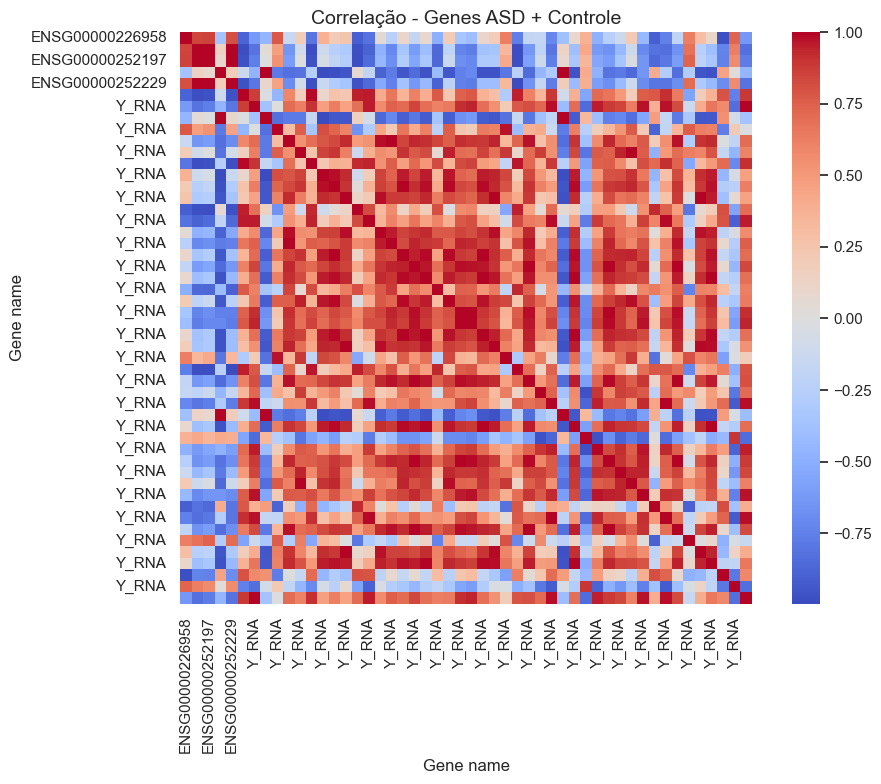

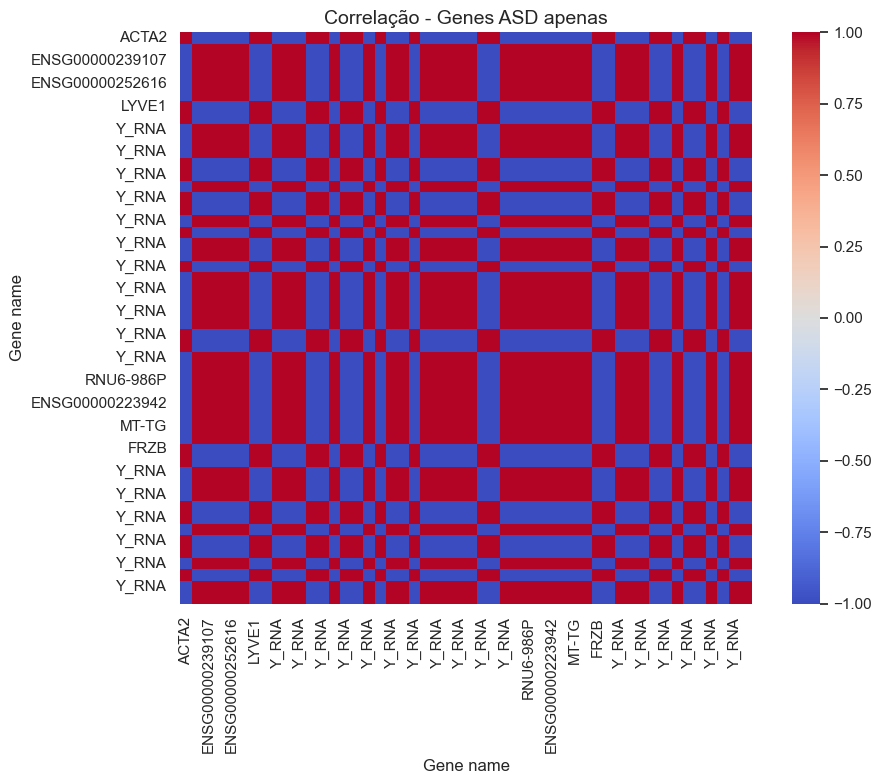

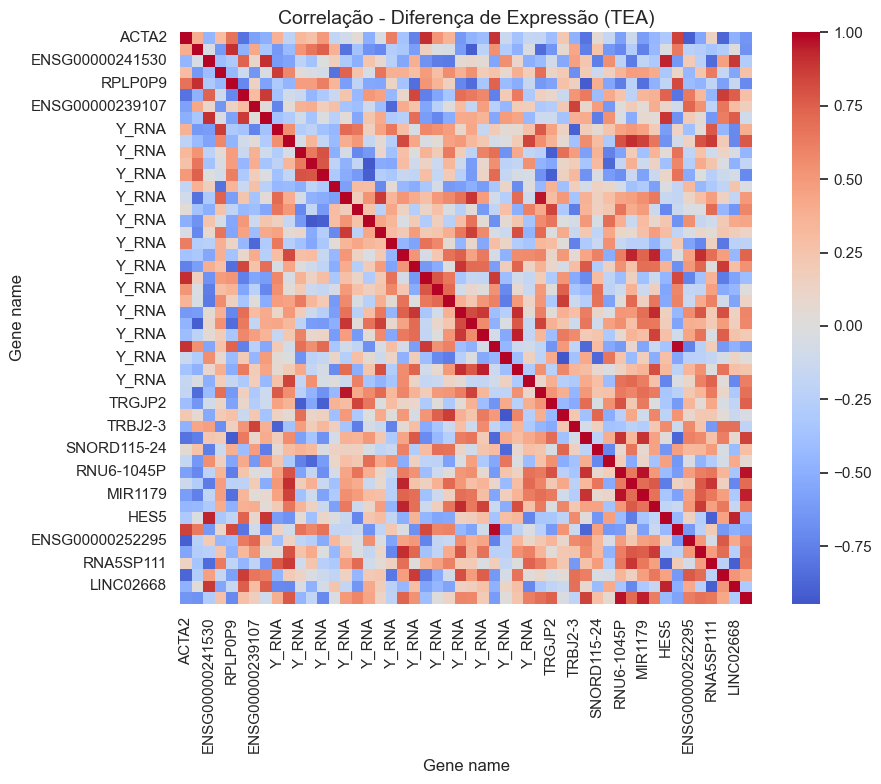

In [82]:
plot_corr_heatmap(corr_asd_controle, "Correlação - Genes ASD + Controle")
plot_corr_heatmap(corr_asd, "Correlação - Genes ASD apenas")
plot_corr_heatmap(corr_diff_tea, "Correlação - Diferença de Expressão (TEA)")

## **Grafos**

In [86]:

def generate_graphs(
    corr_matrix, 
    threshold=0.85, 
    min_grau=5, 
    max_nodes=150, 
    top_labels=10,
    top_edges=3000,
    plot=True,
    title="",
):
    

    edges = np.where(np.abs(corr_matrix.values) > threshold)
    edge_list = [
        (corr_matrix.index[i], corr_matrix.columns[j], corr_matrix.values[i, j])
        for i, j in zip(*edges) if i < j
    ]

    G = nx.Graph()
    G.add_weighted_edges_from(edge_list)


    genes_importantes = [n for n, d in G.degree() if d >= min_grau]
    G_reduzido = G.subgraph(genes_importantes).copy()

    print(f"Grafo reduzido: {G_reduzido.number_of_nodes()} nós, {G_reduzido.number_of_edges()} arestas (|r| > {threshold}, grau ≥ {min_grau})")

    if G_reduzido.number_of_edges() > top_edges:
        edges_sorted = sorted(G_reduzido.edges(data=True), key=lambda e: abs(e[2]['weight']), reverse=True)
        G_reduzido = nx.Graph()
        G_reduzido.add_weighted_edges_from([(u, v, w['weight']) for u, v, w in edges_sorted[:top_edges]])

    if plot:

        if G_reduzido.number_of_nodes() > max_nodes:
            top_genes = sorted(G_reduzido.degree, key=lambda x: x[1], reverse=True)[:max_nodes]
            G_plot = G_reduzido.subgraph([n for n, _ in top_genes])
        else:
            G_plot = G_reduzido

        plt.figure(figsize=(10, 8))
        pos = nx.spring_layout(G_plot, seed=42)
        graus = dict(G_plot.degree())
        
        # Nós coloridos por grau
        nodes = nx.draw_networkx_nodes(
            G_plot, pos,
            node_size=[v*10 for v in graus.values()],
            node_color=list(graus.values()),
            cmap=plt.cm.plasma,
            alpha=0.8
        )
        nx.draw_networkx_edges(G_plot, pos, alpha=0.2)


        top_hubs = sorted(graus.items(), key=lambda x: x[1], reverse=True)[:top_labels]
        nx.draw_networkx_labels(G_plot, pos, labels={g: g for g, _ in top_hubs}, font_size=9, font_color='black')

        plt.title(f"Grafo de Coexpressão {title} (|r| > {threshold})")
        plt.axis("off")
        plt.colorbar(nodes, label="Grau de conectividade")
        plt.savefig(f"../../assets/images/Grafo {title}.png")
        plt.show()

    return G_reduzido


Grafo reduzido: 287 nós, 11804 arestas (|r| > 0.9, grau ≥ 10)


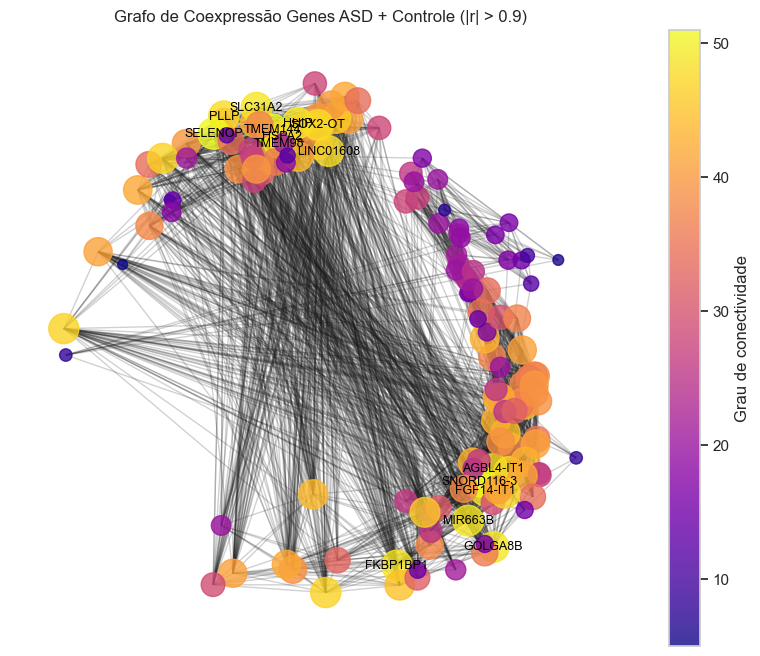

Grafo reduzido: 286 nós, 40756 arestas (|r| > 0.9, grau ≥ 10)


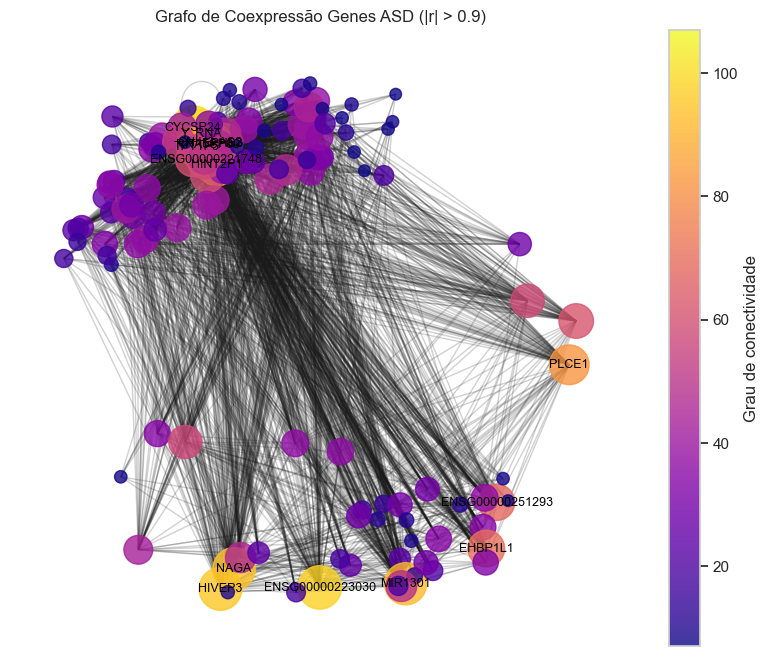

Grafo reduzido: 166 nós, 1095 arestas (|r| > 0.9, grau ≥ 5)


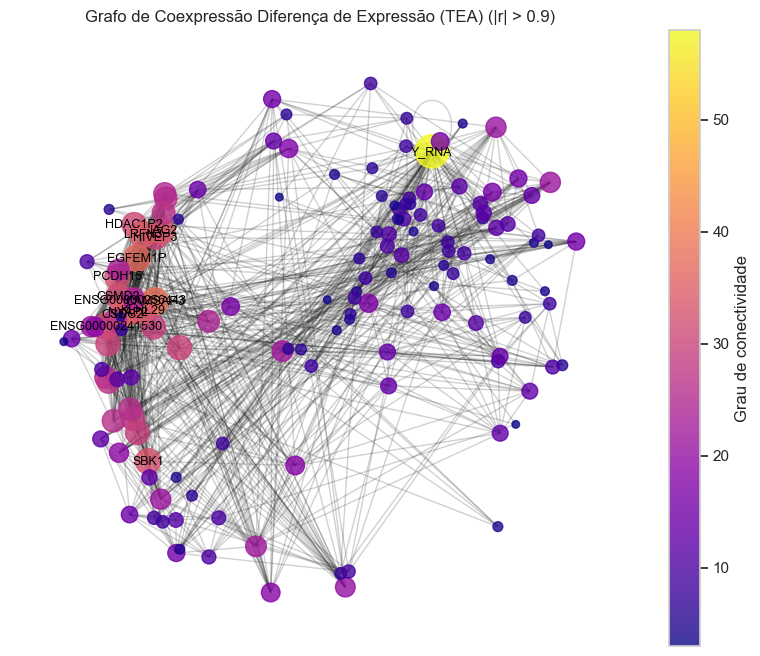

In [87]:
G_asd_controle = generate_graphs(corr_asd_controle, threshold=0.9, min_grau=10, top_labels=15, title="Genes ASD + Controle")
G_asd = generate_graphs(corr_asd, threshold=0.9, min_grau=10, top_labels=15, title="Genes ASD")
G_diff_tea = generate_graphs(corr_diff_tea, threshold=0.9, min_grau=5, top_labels=15, title="Diferença de Expressão (TEA)")

In [39]:
def most_relevant_genes(G, top_n=50):
    """
    Retorna uma lista dos genes mais conectados (hubs) de um grafo.
    
    Parâmetros:
    - G: networkx.Graph
    - top_n: número de genes a retornar
    
    Retorna:
    - lista de genes ordenada pelo grau (mais conectados primeiro)
    """
    graus = dict(G.degree())
    top_genes = sorted(graus.items(), key=lambda x: x[1], reverse=True)[:top_n]
    return [g for g, _ in top_genes]


In [40]:
genes_asd_controle = most_relevant_genes(G_asd_controle, top_n=30)
genes_asd = most_relevant_genes(G_asd, top_n=30)
genes_diff_tea = most_relevant_genes(G_diff_tea, top_n=30)

print("Top genes ASD Controle:", genes_asd_controle)
print("Top genes ASD:", genes_asd)
print("Top genes Diff TEA:", genes_diff_tea)

Top genes ASD Controle: ['Y_RNA', 'TMEM144', 'SNORD116-3', 'SELENOP', 'GOLGA8B', 'FKBP1BP1', 'TMEM98', 'SLC31A2', 'FGF14-IT1', 'HHIP', 'MIR663B', 'HSPA2', 'AGBL4-IT1', 'LINC01608', 'PLLP', 'SOX2-OT', 'PMP22', 'RPS23', 'ENSG00000238615', 'OPALIN', 'RNU6-457P', 'SPP1', 'ENSG00000221185', 'MIR548F2', 'ENSG00000214479', 'ENSG00000238678', 'MAG', 'SNORD116-7', 'GPR37', 'CNP']
Top genes ASD: ['Y_RNA', 'CYCSP24', 'ENSG00000223030', 'MIR1301', 'HIVEP3', 'NAGA', 'CNIH3-AS2', 'HINT2P1', 'RNA5SP60', 'TPT1P5', 'EPHB3', 'PLCE1', 'ENSG00000221748', 'SRP54-AS1', 'EHBP1L1', 'ENSG00000251293', 'DNAJC8P2', 'BICC1', 'ENSG00000243685', 'MIR541', 'ENSG00000248624', 'ENSG00000182404', 'LINC01250', 'TSHZ2', 'KCNK15-AS1', 'ZBTB46', 'SLC6A12', 'ACTA2', 'RN7SKP53', 'ENTREP3']
Top genes Diff TEA: ['Y_RNA', 'CAMSAP3', 'EGFEM1P', 'CSDC2', 'ENSG00000241530', 'LRFN3', 'NYAP2', 'JAG2', 'KLHL29', 'ENSG00000256443', 'SBK1', 'CSMD2', 'PCDH15', 'HDAC1P2', 'HIVEP3', 'ADAM19', 'ENSG00000257954', 'ANP32CP', 'FGD1', 'CHST7',

In [41]:
# Combina todas as listas de top genes e converte em lista
todos_genes = list(set(genes_asd_controle + genes_asd + genes_diff_tea))

# Cria DataFrame binário: 1 se gene está presente no top 30 daquela condição, 0 caso contrário
df_genes = pd.DataFrame(index=todos_genes)
df_genes['ASD_Controle'] = df_genes.index.isin(genes_asd_controle).astype(int)
df_genes['ASD'] = df_genes.index.isin(genes_asd).astype(int)
df_genes['Diff_TEA'] = df_genes.index.isin(genes_diff_tea).astype(int)

# Ordena pelo número de condições em que o gene aparece
df_genes['Total'] = df_genes.sum(axis=1)
df_genes = df_genes.sort_values(by=['Total', 'ASD_Controle', 'ASD', 'Diff_TEA'], ascending=False)
df_genes = df_genes.drop(columns='Total')


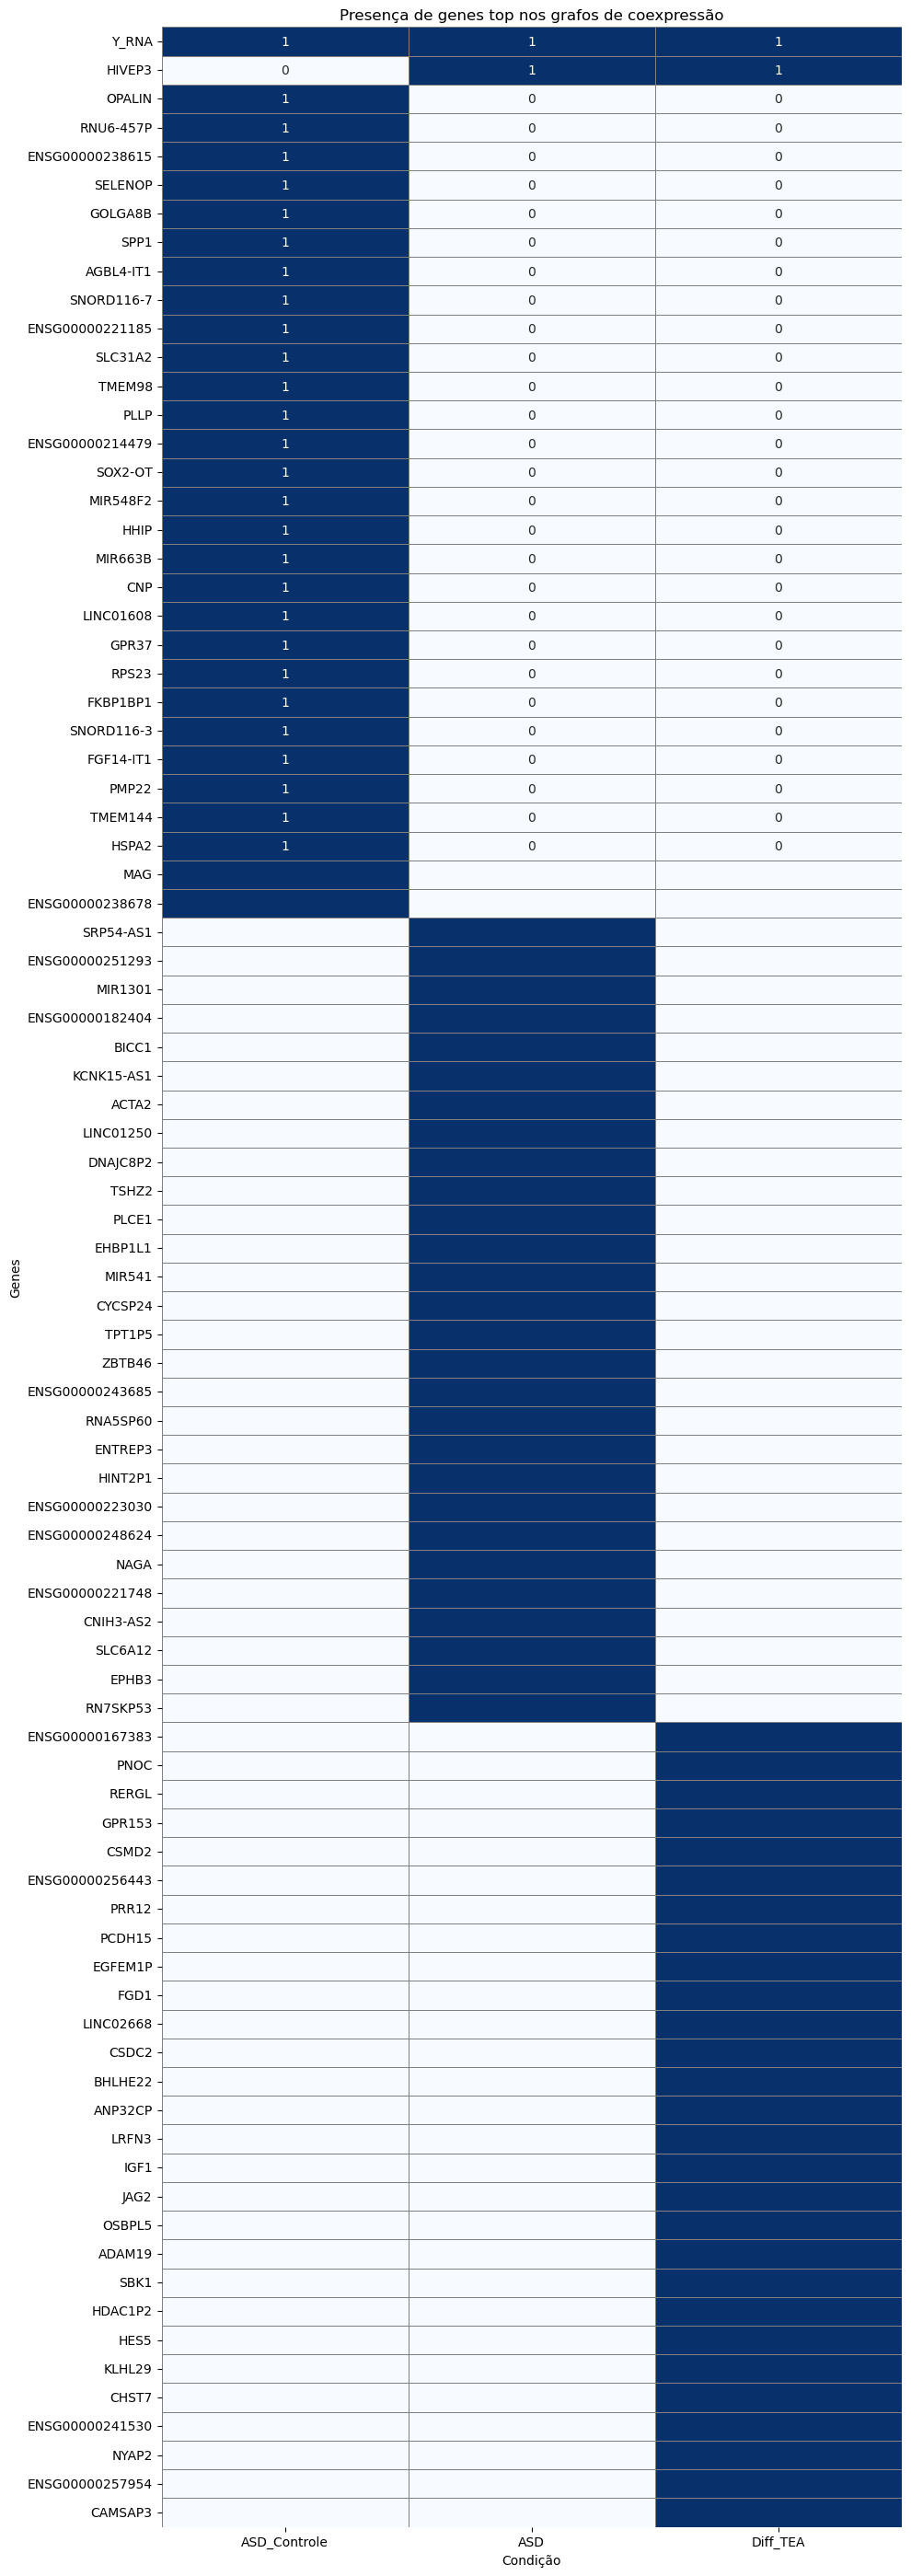

In [42]:
plt.figure(figsize=(10, len(df_genes)*0.3 + 2))
sns.heatmap(df_genes, cmap='Blues', cbar=False, linewidths=0.5, linecolor='gray', annot=True, fmt='d')
plt.title("Presença de genes top nos grafos de coexpressão")
plt.xlabel("Condição")
plt.ylabel("Genes")
plt.tight_layout()
plt.show()


# Base E-MTAB-13871 (sangue)

In [49]:
df1_sangue = pd.read_csv(r"../../data/processed/sangue/expressão diferencial sangue - TEA feminino (em relação ao TEA masculino).csv", sep=";")
df2_sangue = pd.read_csv(r"../../data/processed/sangue/expressão diferencial sangue - TEA masculino (em relação ao controle masculino).csv", sep=";")
df_sfari = pd.read_csv(r"../../data/processed/SFARI-Gene_genes_10-23-2025release_11-11-2025export.csv")

In [50]:
#renomear as colunas
df1_fem_vs_masc = df1_sangue.rename(columns={"log2 FC":"log2FC_F_vs_M_TEA", "log10 p-value":"log10p_F_vs_M_TEA"}).copy()
df2_masc_vs_controle = df2_sangue.rename(columns={"log2 FC":"log2FC_M_vs_Controle", "log10 p-value":"log10p_M_vs_Controle"}).copy()

In [51]:
df1_fem_vs_masc.columns, df2_masc_vs_controle.columns

(Index(['GeneID', 'log2FC_F_vs_M_TEA', 'log10p_F_vs_M_TEA'], dtype='object'),
 Index(['GeneID', 'log2FC_M_vs_Controle', 'log10p_M_vs_Controle'], dtype='object'))

In [52]:
df_corr = pd.merge(
    df1_fem_vs_masc, 
    df2_masc_vs_controle, 
    on='GeneID', 
    how='inner'
)


In [53]:
#Change ',' for '.' and convert to float
for col in df_corr.columns:
    if col != "GeneID":
        df_corr[col] = df_corr[col].astype(str).str.replace(',', '.').astype(float)

In [54]:
df_corr.dtypes, df_corr.shape

(GeneID                   object
 log2FC_F_vs_M_TEA       float64
 log10p_F_vs_M_TEA       float64
 log2FC_M_vs_Controle    float64
 log10p_M_vs_Controle    float64
 dtype: object,
 (17748, 5))

In [55]:
#Calculate correlation across the genes
correlacao, p_valor = pearsonr(
    df_corr['log2FC_F_vs_M_TEA'], 
    df_corr['log2FC_M_vs_Controle']
)

print("-" * 40)
print(f"Coeficiente de Correlação (r) de Pearson: {correlacao:.4f}")
print(f"P-valor da Correlação: {p_valor:.4e}")
print("-" * 40)

----------------------------------------
Coeficiente de Correlação (r) de Pearson: -0.1897
P-valor da Correlação: 1.9773e-143
----------------------------------------


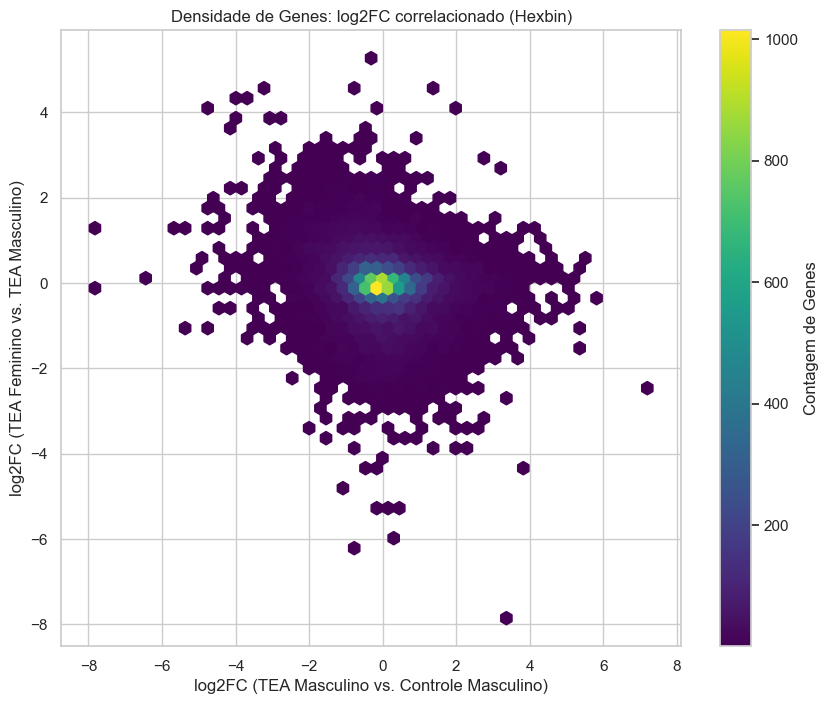

In [88]:
# Configurando o tema
sns.set_theme(style="whitegrid")

plt.figure(figsize=(10, 8))

# Criando o Hexbin Plot
plt.hexbin(
    df_corr['log2FC_M_vs_Controle'], 
    df_corr['log2FC_F_vs_M_TEA'], 
    gridsize=50, # Número de hexágonos na grade (maior = mais detalhe)
    cmap='viridis', # Mapa de cores (viridis é bom para densidade)
    mincnt=1 # Exibe apenas hexágonos com pelo menos 1 ponto
)

cb = plt.colorbar(label='Contagem de Genes') # Barra de cor para densidade
plt.title('Densidade de Genes: log2FC correlacionado (Hexbin)')
plt.xlabel('log2FC (TEA Masculino vs. Controle Masculino)')
plt.ylabel('log2FC (TEA Feminino vs. TEA Masculino)')
plt.savefig("../../assets/images/densidade_de_genes_log2FC_correlacionado_Hexbin.png")
plt.show()

c:\Users\luis\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\luis\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


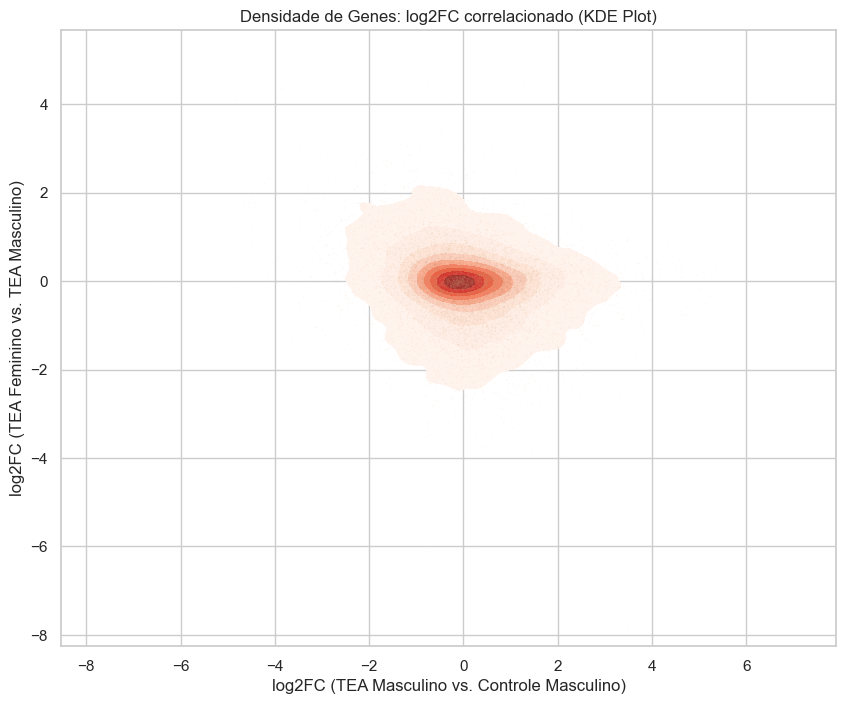

In [84]:
plt.figure(figsize=(10, 8))

# Criando o KDE Plot com contornos
sns.kdeplot(
    x=df_corr['log2FC_M_vs_Controle'], 
    y=df_corr['log2FC_F_vs_M_TEA'], 
    data=df_corr,
    fill=True, # Preenche a área do contorno
    cmap="Reds", # Mapa de cores para o preenchimento
    levels=10 # Número de níveis/contornos
)

# Adicionando um scatter plot com alta transparência para visualização adicional
sns.scatterplot(
    x='log2FC_M_vs_Controle', 
    y='log2FC_F_vs_M_TEA', 
    data=df_corr,
    alpha=0.05, # Transparência MUITO alta para 17k dados
    s=1 # Tamanho mínimo do ponto
)

plt.title('Densidade de Genes: log2FC correlacionado (KDE Plot)')
plt.xlabel('log2FC (TEA Masculino vs. Controle Masculino)')
plt.ylabel('log2FC (TEA Feminino vs. TEA Masculino)')
plt.savefig("../../assets/images/Densidade de Genes_log2FC_correlacionado_(KDE_plot).png")
plt.show()

In [59]:
df_corr

,GeneID,log2FC_F_vs_M_TEA,log10p_F_vs_M_TEA,log2FC_M_vs_Controle,log10p_M_vs_Controle
0,A1BG-AS1,0.365698,-0.735200,-0.126705,-0.179550
1,A2M,-0.071272,-0.056389,-1.355089,-1.537169
2,A2M-AS1,-0.866768,-0.658708,1.000782,-0.750534
3,A3GALT2,1.227291,-1.037978,0.293874,-0.114854
4,AAAS,-0.028633,-0.192441,-0.274215,-0.411379
...,...,...,...,...,...
17743,ZXDC,-0.180572,-0.845648,0.358398,-1.627936
17744,ZYG11A,2.221121,-1.673179,-1.148669,-0.582826
17745,ZYG11B,0.122990,-0.298198,0.520458,-0.885138
17746,ZZEF1,-0.037089,-0.221733,-0.068295,-0.171147


In [60]:
limiar = 1.3 # p-value <= 0.05

df_corr['log10p_F_vs_M_TEA'] = np.abs(df_corr['log10p_F_vs_M_TEA'])
df_corr['log10p_M_vs_Controle'] = np.abs(df_corr['log10p_M_vs_Controle'])

genes_pvalue = df_corr[
    (df_corr['log10p_F_vs_M_TEA'] >= limiar) |  
    (df_corr['log10p_M_vs_Controle'] >= limiar) 
].copy()
genes_pvalue.shape

(5496, 5)

In [61]:
limiar_log2FC = 1.0
genes_log2fc = genes_pvalue[
    (genes_pvalue['log2FC_F_vs_M_TEA'].abs() >= limiar_log2FC) | 
    (genes_pvalue['log2FC_M_vs_Controle'].abs() >= limiar_log2FC)
].copy()
genes_log2fc.shape

(2360, 5)

In [62]:
df_genes_candidatos = genes_log2fc.merge(
    df_sfari[['gene-symbol', 'gene-score', 'genetic-category']],
    left_on='GeneID',  
    right_on='gene-symbol',
    how='left'
).drop(columns=['gene-symbol'], errors='ignore')

In [63]:
# edit to use on cytoscape

df_atributos = genes_log2fc.copy()

df_atributos['Influencia_Absoluta_F_M'] = np.abs(df_atributos['log2FC_F_vs_M_TEA'])
df_atributos['Influencia_Absoluta_M_Controle'] = np.abs(df_atributos['log2FC_M_vs_Controle'])

df_atributos['Influencia_Combinada'] = (
    df_atributos['Influencia_Absoluta_F_M'] + 
    df_atributos['Influencia_Absoluta_M_Controle']
) / 2

# 2. Rename columns with o log2FC to use to compare Tea with Control
df_atributos.rename(columns={'log2FC_M_vs_Controle': 'Cor_Log2FC_TEA_M_vs_C'}, inplace=True)

# Selected and reorganize relevants columns to use on Cytoscape
colunas_cytoscape = [
    'GeneID', 
    'Influencia_Combinada', 
    'Cor_Log2FC_TEA_M_vs_C', 
    'log10p_M_vs_Controle',
    'log2FC_F_vs_M_TEA' 
]
df_atributos_final = df_atributos[colunas_cytoscape]
df_atributos_final.set_index('GeneID', inplace=True)

print("DataFrame de Atributos Finalizado (pronto para exportação).")

DataFrame de Atributos Finalizado (pronto para exportação).


In [64]:
df_atributos_final.to_csv('../../data/processed/sangue/cytoscape_node_attributes.tsv', sep='\t')

In [65]:
list_genes_log2fc = genes_log2fc['GeneID'].tolist()
list_genes_log2fc

['A2M',
 'ABCA1',
 'ABCA7',
 'ABCC6',
 'ABHD1',
 'ABHD2',
 'ABHD3',
 'ABL1',
 'ABLIM3',
 'ABTB2',
 'AC000089.1',
 'AC002059.1',
 'AC002075.2',
 'AC002091.2',
 'AC002116.2',
 'AC002456.1',
 'AC002467.1',
 'AC003102.1',
 'AC004069.1',
 'AC004130.2',
 'AC004233.2',
 'AC004241.1',
 'AC004263.2',
 'AC004687.1',
 'AC004771.2',
 'AC004877.1',
 'AC004938.2',
 'AC004951.1',
 'AC004951.2',
 'AC005034.5',
 'AC005070.3',
 'AC005072.1',
 'AC005076.1',
 'AC005082.1',
 'AC005264.1',
 'AC005730.3',
 'AC005785.1',
 'AC005840.2',
 'AC005840.4',
 'AC005912.1',
 'AC005944.1',
 'AC005954.1',
 'AC006033.2',
 'AC006042.2',
 'AC006064.4',
 'AC006077.2',
 'AC006213.7',
 'AC006330.1',
 'AC006435.2',
 'AC006504.5',
 'AC006538.1',
 'AC006978.1',
 'AC007191.1',
 'AC007292.2',
 'AC007298.2',
 'AC007342.3',
 'AC007342.7',
 'AC007378.1',
 'AC007384.1',
 'AC007390.1',
 'AC007406.4',
 'AC007546.3',
 'AC007637.1',
 'AC007663.1',
 'AC007773.1',
 'AC007785.3',
 'AC007879.3',
 'AC008026.3',
 'AC008038.1',
 'AC008079.1',
 '

In [66]:
genes_log2fc["log2FC_F_vs_M_TEA"].max(), genes_log2fc["log2FC_M_vs_Controle"].max() 

(5.271474388, 7.345495964)

In [68]:
if len(genes_log2fc) > 0:
    genes_log2fc['Influencia_Combinada'] = (
        np.abs(genes_log2fc['log2FC_F_vs_M_TEA']) + 
        np.abs(genes_log2fc['log2FC_M_vs_Controle'])
    )

    
    top_20_log2fc = genes_log2fc.sort_values(
        by='Influencia_Combinada', 
        ascending=False
    ).head(20)
    print(top_20_log2fc[['GeneID', 'log2FC_F_vs_M_TEA', 'log2FC_M_vs_Controle', 'Influencia_Combinada']])
    
    # Salvar a lista para Análise de Enriquecimento Funcional
    gene_ids_influentes = top_20_log2fc['GeneID'].tolist()
    print("\nLista de GeneIDs para Análise GO/KEGG:", gene_ids_influentes)

else:
    print("\n Nenhum gene atendeu ao filtro de |log2FC| >= 1.0 nas duas comparações.")

            GeneID  log2FC_F_vs_M_TEA  log2FC_M_vs_Controle  \
2758        ALOX15          -2.519005              7.345496   
7363        GPX1P1           4.113543             -4.834922   
1267    AC092490.1          -4.437785              3.869318   
7604          HCP5           4.339103             -3.868761   
13651      SCGB3A1           4.342829             -3.826970   
8059     IGKV1D-13           3.703047             -4.296957   
5503        DDX39B           3.785259             -4.044088   
12008      PPIAP45           4.415957             -3.226090   
6277          EREG           1.217424             -5.798083   
13518  RUNDC3A-AS1           3.927762             -2.921787   
12262       PRSS33          -1.411235              5.312454   
13209     RPL23AP2           2.341077             -4.153647   
8486        KCNMA1           3.019498             -3.465505   
6900          FTCD           3.757821             -2.702207   
7959           ID1           1.205249             -5.24